# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
df = pd.read_csv('data/baseball.csv')
df.head()

,Outlook,Temperature,Humidity,Wind,Play Golf
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [3]:
labels = df['Play Golf']
print('Total count of values in Play Golf: ', len(labels))
print('Total count of each unique value in Play Golf: \n', labels.value_counts())

Total count of values in Play Golf:  14
Total count of each unique value in Play Golf: 
 Yes    9
No     5
Name: Play Golf, dtype: int64


# Utils

In [4]:
def entropy(labels):
    p = labels.value_counts() / len(labels)
    return -sum(p * np.log2(p))

In [5]:
def information_gain(df, parent, child):
    entropy_parent = entropy(df[parent])
    
    entropy_child = 0
    for value in df[child].unique():
        subset = df[df[child] == value]
        wi = len(subset) / len(df)
        entropy_child += wi * entropy(subset[parent])
        
    return entropy_parent - entropy_child

In [6]:
information_gain(df, 'Play Golf', 'Wind')

0.04812703040826949

# ID3 (from scratch)

In [9]:
class Node:
    
    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label
        self.children = {}
        
    def __repr__(self):
        if self.feature is not None:
            return f'DecisionNode(child="{self.feature}", children={self.children})'
        else:
            return f'LeafNode(label="{self.label}")'

In [16]:
def make_tree(df, parent):
    
    # if all the instances in the current subset belong to the same class, a leaf node is created
    if len(df[parent].unique()) == 1:
        return Node(label=df[parent].iloc[0])
    
    children = df.drop(parent, axis=1).columns
    
    # if there are no more features to split on or no more instances left, a leaf node is created with the most common class label
    if len(children) == 0 or len(df) == 0:
        return Node(label=df[parent].mode()[0])
    
    gains = [information_gain(df, parent, feature) for feature in children]
    
    max_gain_idx = np.argmax(gains)
    best_feature = children[max_gain_idx]
    
    node = Node(feature=best_feature)
    
    for value in df[best_feature].unique():
        subset = df[df[best_feature] == value].drop(best_feature, axis=1)
        node.children[value] = make_tree(subset, parent)
    
    return node

In [17]:
tree = make_tree(df, 'Play Golf')
tree

DecisionNode(child="Outlook", children={'Sunny': DecisionNode(child="Humidity", children={'High': LeafNode(label="No"), 'Normal': LeafNode(label="Yes")}), 'Overcast': LeafNode(label="Yes"), 'Rain': DecisionNode(child="Wind", children={'Weak': LeafNode(label="Yes"), 'Strong': LeafNode(label="No")})})

# Evaluation

In [97]:
def predict(node, sample):
    if node.child is None:
        return node.label
    
    child_value = sample[node.child]
    
    if child_value in node.children:
        return predict(node.children[child_value], sample)
    else:
        return node.label

In [98]:
[predict(tree, sample) for _, sample in df.iterrows()]

['No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No']

# Decision Tree (sklearn)

### Classification

In [18]:
from sklearn.datasets import load_iris
from sklearn import tree

In [19]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((112, 4), (38, 4))

In [20]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42, ccp_alpha=0.1)

In [21]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.1, max_depth=3, random_state=42)

In [22]:
clf.score(X_test, y_test)

0.8947368421052632

### Regression

In [24]:
df = pd.read_csv('data/energy-train-l.csv')
train_set = np.array(df)

x_train = train_set[:, :-1]
y_train = train_set[:, -1:]

df = pd.read_csv('data/energy-test-l.csv')
test_set = np.array(df)

x_test = test_set[:, :-1]
y_test = test_set[:, -1:]

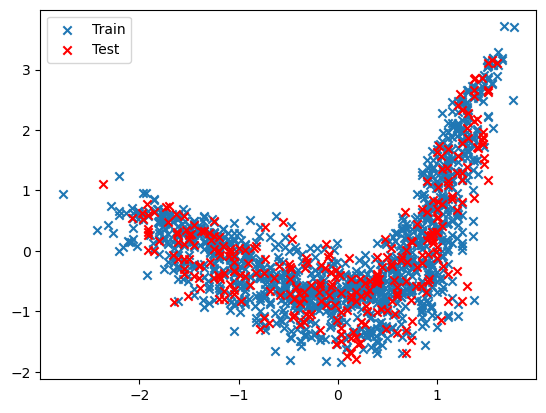

In [26]:
plt.scatter(x_train, y_train, marker='x')
plt.scatter(x_test, y_test, c='r', marker='x')

plt.legend(['Train', 'Test'])

In [29]:
depth = 4 
reg = tree.DecisionTreeRegressor(max_depth=depth, ccp_alpha=0.05)

In [30]:
reg.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.05, max_depth=4)

In [31]:
# Generate data points for plotting
xp = np.arange(x_train.min(), x_train.max(), 0.01)[:, np.newaxis]
yp = reg.predict(xp)

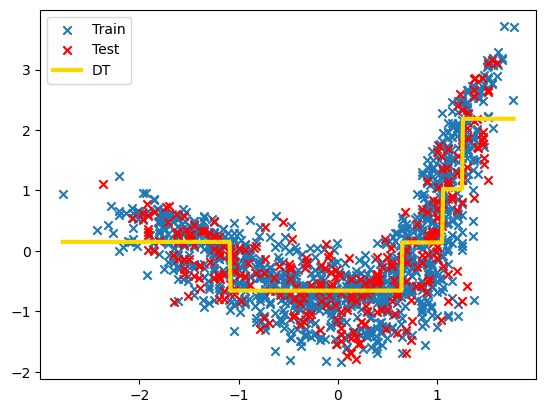

In [32]:
plt.scatter(x_train, y_train, marker='x')
plt.scatter(x_test, y_test, c='r', marker='x')
plt.plot(xp, yp, color='gold', linewidth=3)

plt.legend(['Train', 'Test', 'DT'])

In [28]:
reg.score(x_test, y_test)

0.6102814513496133